In [2]:
# Import necessary libraries
import tensorflow as tf  # Import TensorFlow, an open-source machine learning framework
import numpy as np  # Import NumPy, a library for handling large multi-dimensional arrays and matrices
import matplotlib.pyplot as plt  # Import Matplotlib for creating visualizations like plots and graphs
import math  # Import Python's math library for mathematical functions
import time  # Import time library to measure the time for various operations

# Import VGG16 model and Keras Model API from TensorFlow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input  # Import the VGG16 model architecture from Keras, and a preprocessing function for images

# Import the functions to load and process images
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Load images from files and convert them to NumPy arrays
from tensorflow.keras.models import Model  # Import the Keras Model class to build and manage neural network models

# Printing the imported libraries for verification
print("Libraries imported successfully: TensorFlow, NumPy, Matplotlib, math, time")
print("VGG16 and necessary Keras modules are ready for use.")

Libraries imported successfully: TensorFlow, NumPy, Matplotlib, math, time
VGG16 and necessary Keras modules are ready for use.


In [3]:
# Function to load and process an image
def load_and_process_image(image_path):
    # Load the image from the given file path
    img = load_img(image_path)
    #print(f"Image loaded from {image_path}")

    # Convert the loaded image into a NumPy array (so that it can be fed into a neural network)
    img = img_to_array(img)
    #print(f"Image converted to NumPy array with shape: {img.shape}")

    # Preprocess the image to fit the input requirements of VGG16 (mean subtraction, etc.)
    img = preprocess_input(img)
    #print("Image preprocessed for VGG16 input.")

    # Expand the dimensions of the image array to include a batch dimension (VGG16 expects 4D input)
    img = np.expand_dims(img, axis=0)
    print(f"Image shape after adding batch dimension: {img.shape}")

    # Return the processed image ready for model input
    return img

In [4]:
# Function to deprocess the image (inverse of preprocessing)
def deprocess(img):
    # Perform the inverse of the preprocessing step: add the mean values back to each channel
    img[:, :, 0] += 103.939  # Add the mean value of the Red channel
    img[:, :, 1] += 116.779  # Add the mean value of the Green channel
    img[:, :, 2] += 123.68   # Add the mean value of the Blue channel
    #print("Mean values added back to each channel.")

    # Convert from RGB (as used in preprocessing) to BGR (as used by VGG16)
    img = img[:, :, ::-1]  # Reverse the channel order: RGB -> BGR
    #print("Converted image from RGB to BGR.")

    # Clip the pixel values to ensure they are within the valid range [0, 255], then convert to 'uint8'
    img = np.clip(img, 0, 255).astype('uint8')  # Ensures that pixel values are between 0 and 255 and of the correct type
    #print("Clipped and converted image to uint8.")

    # Return the deprocessed image
    return img

In [ ]:
def display_image(image):
    # Remove batch dimension if present
    if len(image.shape) == 4:
        img = np.squeeze(image, axis=0)  # Remove the batch dimension
    else:
        img = image  # If no batch dimension exists, use the image directly

    # Deprocess the image (reverse the preprocessing)
    img = deprocess(img)

    # Display the image with Matplotlib
    plt.grid(False)  # Remove grid lines
    plt.xticks([])   # Remove x-axis ticks
    plt.yticks([])   # Remove y-axis ticks
    plt.imshow(img)  # Display the image

    return

Image shape after adding batch dimension: (1, 183, 275, 3)


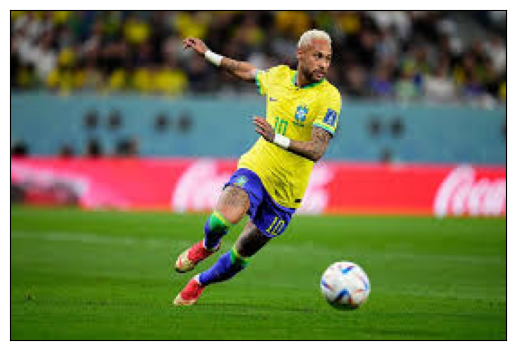

In [5]:
# load content image
content_img_path = '/content/images.jfif'
content_img = load_and_process_image(content_img_path)
display_image(content_img)

Image shape after adding batch dimension: (1, 206, 245, 3)


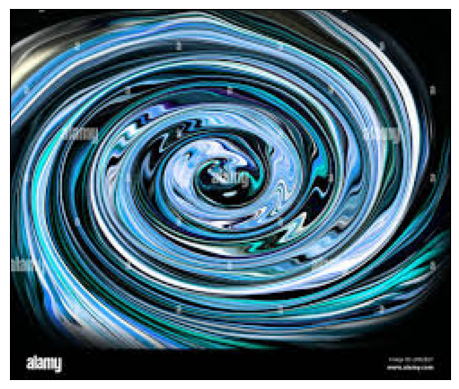

In [6]:
# load style image
style_img_path = '/content/Cyan_image.jfif'
style_img = load_and_process_image(style_img_path)
display_image(style_img)

In [7]:
# download the VGG16 model and initialise it
model = VGG16(
	include_top=False,
	weights='imagenet'
)
# set training to False
model.trainable = False

# Print details of different layers
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
# Define the content model by selecting a specific layer of the pre-trained VGG16 model
content_layer = 'block5_conv2'  # Set the layer we want to extract features from for content representation
print(f"Selected content layer: {content_layer}")

# Create a new model that outputs the feature map of the chosen layer
content_model = Model(
    inputs=model.input,  # Input to the model is the same as the original model input
    outputs=model.get_layer(content_layer).output  # Output of the new model is the feature map of the selected layer
)

# Print the summary of the content model to verify the architecture
content_model.summary()

Selected content layer: block5_conv2


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,354,880 (47.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,354,880 (47.13 MB)

In [9]:
# Define the style model by selecting multiple layers from the VGG16 model for style representation
style_layers = [
    'block1_conv1',  # Layer 1: The first convolutional layer from block 1 (captures fine-grained style features)
    'block3_conv1',  # Layer 2: The first convolutional layer from block 3 (captures medium-level style features)
    'block5_conv1'   # Layer 3: The first convolutional layer from block 5 (captures high-level style features)
]
print(f"Selected style layers: {style_layers}")

# Create a list of models, each extracting the feature map from a different style layer
style_models = [
    Model(inputs=model.input,  # Input to the model is the same as the original model input
          outputs=model.get_layer(layer).output)  # Output is the feature map from the selected style layer
    for layer in style_layers
]

# Printing the summaries of each style model to confirm their structure
for i, style_model in enumerate(style_models):
    print(f"Summary of style model {i+1} for layer {style_layers[i]}:")
    style_model.summary()

Selected style layers: ['block1_conv1', 'block3_conv1', 'block5_conv1']
Summary of style model 1 for layer block1_conv1:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,792 (7.00 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,792 (7.00 KB)

Summary of style model 2 for layer block3_conv1:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 555,328 (2.12 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 555,328 (2.12 MB)

Summary of style model 3 for layer block5_conv1:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,995,072 (38.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,995,072 (38.13 MB)

In [10]:
# Function to compute the content loss between the content and generated images
def content_loss(content, generated):
    # Get the activations (feature maps) for the content image from the content model
    a_C = content_model(content)
    print(f"Content activations shape: {a_C.shape}")  # Print the shape of the activations for content

    # Get the activations (feature maps) for the generated image from the content model
    a_G = content_model(generated)  # Compute activations for the generated image
    print(f"Generated activations shape: {a_G.shape}")  # Print the shape of the activations for generated image

    # Compute the mean squared error between the content activations and the generated activations
    loss = tf.reduce_mean(tf.square(a_C - a_G))  # This calculates the content loss
    print(f"Content loss: {loss.numpy()}")  # Print the computed content loss value

    # Return the content loss value
    return loss

In [11]:
# Function to compute the Gram matrix of a given tensor
def gram_matrix(A):
    # Get the number of channels in the input tensor (i.e., the depth of the feature map)
    channels = int(A.shape[-1])
    #print(f"Number of channels in the feature map: {channels}")

    # Reshape the tensor to have shape [batch_size * height * width, channels]
    # Flatten the spatial dimensions (height * width) while keeping the channels dimension
    a = tf.reshape(A, [-1, channels])
    #print(f"Reshaped tensor shape: {a.shape}")  # Print the shape after reshaping

    # Get the number of elements (pixels) in the reshaped tensor
    n = tf.shape(a)[0]
    #print(f"Number of elements (pixels) in the reshaped tensor: {n}")

    # Compute the Gram matrix by performing matrix multiplication
    # This captures the correlations between different channels
    gram = tf.matmul(a, a, transpose_a=True)
    #print(f"Gram matrix shape: {gram.shape}")  # Print the shape of the Gram matrix

    # Normalize the Gram matrix by dividing by the number of elements (pixels) in the flattened tensor
    return gram / tf.cast(n, tf.float32)  # Normalize by casting n to float32 to match the data type


# Calculate the weight for each style layer
weight_of_layer = 1. / len(style_models)  # The weight is the inverse of the number of style layers
print(f"Weight of each style layer: {weight_of_layer}")

Weight of each style layer: 0.3333333333333333


In [12]:
# Function to compute the style loss between the style and generated images
def style_cost(style, generated):
    # Initialize the total style loss (J_style) to 0
    J_style = 0
    #print("Initialized total style loss: J_style = 0")

    # Loop through each style model corresponding to the selected style layers
    for i, style_model in enumerate(style_models):
        #print(f"\nProcessing style model {i+1} for layer {style_layers[i]}")

        # Get the activations (feature maps) for the style image from the current style model
        a_S = style_model(style)
        #print(f"Shape of activations for style image (Layer {style_layers[i]}): {a_S.shape}")

        # Get the activations (feature maps) for the generated image from the current style model
        a_G = style_model(generated)
        #print(f"Shape of activations for generated image (Layer {style_layers[i]}): {a_G.shape}")

        # Compute the Gram matrix for both style and generated image activations
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        #print(f"Gram matrix for style image (Layer {style_layers[i]}): {GS.shape}")
        #print(f"Gram matrix for generated image (Layer {style_layers[i]}): {GG.shape}")

        # Compute the style loss for this layer (mean squared error between the Gram matrices)
        content_cost = tf.reduce_mean(tf.square(GS - GG))
        print(f"Style loss for layer {style_layers[i]}: {content_cost.numpy()}")

        # Accumulate the style loss and weight it by the layer's contribution (weight_of_layer)
        J_style += content_cost * weight_of_layer
        print(f"Updated total style loss: {J_style.numpy()}")

    # Return the total style loss
    return J_style

In [13]:
# Function to compute content loss between the style and generated images
def content_cost(content, generated):
    # Initialize the total content loss (J_content) to 0
    J_content = 0
    #print("Initialized total content loss: J_content = 0")

    # Get the content activations for the content and generated images from the content model
    a_C = content_model(content)
    #print(f"Content activations (Layer {content_layer}): {a_C.shape}")

    a_G = content_model(generated)
    #print(f"Generated activations (Layer {content_layer}): {a_G.shape}")

    # Compute the content loss (mean squared error between the activations)
    content_cost = tf.reduce_mean(tf.square(a_C - a_G))
    #print(f"Content loss (MSE between activations): {content_cost.numpy()}")

    # Add the content loss to the total content loss
    J_content += content_cost
    #print(f"Updated total content loss: {J_content.numpy()}")

    # Return the total content loss
    return J_content

In [14]:
# List to store generated images at each iteration for visualization
generated_images = []

# Training function for optimizing the generated image using content and style losses
def training_loop(content_path, style_path, iterations=100, a=10, b=1000):
    # Load and preprocess content and style images from their respective paths
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)

    # Initialize the generated image as a trainable variable, starting from the content image
    generated = tf.Variable(content, dtype=tf.float32)

    # Adam optimizer with a learning rate of 7.9
    opt = tf.keras.optimizers.Adam(learning_rate=7.9)

    # Initialize best cost and best image trackers
    best_cost = math.inf
    best_image = None

    # Start the optimization loop for a given number of iterations
    for i in range(iterations):
        # Record start time for CPU and wall time
        start_time_cpu = time.process_time()
        start_time_wall = time.time()

        # Use GradientTape to track operations on the generated image
        with tf.GradientTape() as tape:
            # Compute content loss
            J_content = content_cost(content, generated)  # Note: Pass the content, not style
            # Compute style loss
            J_style = style_cost(style, generated)
            # Compute total loss as a weighted sum of content and style losses
            J_total = a * J_content + b * J_style

        # Compute the gradients of the total loss with respect to the generated image
        grads = tape.gradient(J_total, generated)
        # Apply gradients to the generated image to minimize the total loss
        opt.apply_gradients([(grads, generated)])

        # Record end time for CPU and wall time
        end_time_cpu = time.process_time()  # Record end time for CPU
        end_time_wall = time.time()  # Record end time for wall time

        # Calculate the CPU time (time spent on computations) and wall time (real elapsed time)
        cpu_time = end_time_cpu - start_time_cpu
        wall_time = end_time_wall - start_time_wall

        # If the total loss improves (becomes smaller), store the best image and loss
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()

        # Print CPU times (user, system, and total time)
        print("CPU times: user {} µs, sys: {} ns, total: {} µs".format(
            int(cpu_time * 1e6),  # Convert seconds to microseconds for user time
            int((end_time_cpu - start_time_cpu) * 1e9),  # Convert seconds to nanoseconds for system time
            int((end_time_cpu - start_time_cpu + 1e-6) * 1e6)  # Convert seconds to microseconds for total time
        ))

        # Print wall time (real time taken for each iteration)
        print("Wall time: {:.2f} µs".format(wall_time * 1e6))  # Convert seconds to microseconds

        # Print the current iteration and total loss for each iteration
        print("Iteration: {}".format(i))
        print('Total Loss: {:e}'.format(J_total))  # Print the total loss in scientific notation
        print('--------------------------------------------------------')
        # Append the current generated image to the list for later visualization
        generated_images.append(generated.numpy())

    # Return the best generated image found during optimization
    return best_image

In [15]:
# Train the model and get best image
final_img = training_loop(content_img_path, style_img_path)

Image shape after adding batch dimension: (1, 183, 275, 3)
Image shape after adding batch dimension: (1, 206, 245, 3)
Style loss for layer block1_conv1: 9846886.0
Updated total style loss: 3282295.5
Style loss for layer block3_conv1: 141412663296.0
Updated total style loss: 47140835328.0
Style loss for layer block5_conv1: 19710004.0
Updated total style loss: 47147405312.0
CPU times: user 4720395 µs, sys: 4720395370 ns, total: 4720396 µs
Wall time: 6407586.10 µs
Iteration: 0
Total Loss: 4.714740e+13
--------------------------------------------------------
Style loss for layer block1_conv1: 9330061.0
Updated total style loss: 3110020.5
Style loss for layer block3_conv1: 121238855680.0
Updated total style loss: 40416063488.0
Style loss for layer block5_conv1: 19410602.0
Updated total style loss: 40422535168.0
CPU times: user 186138 µs, sys: 186138254 ns, total: 186139 µs
Wall time: 185499.91 µs
Iteration: 1
Total Loss: 4.042253e+13
--------------------------------------------------------


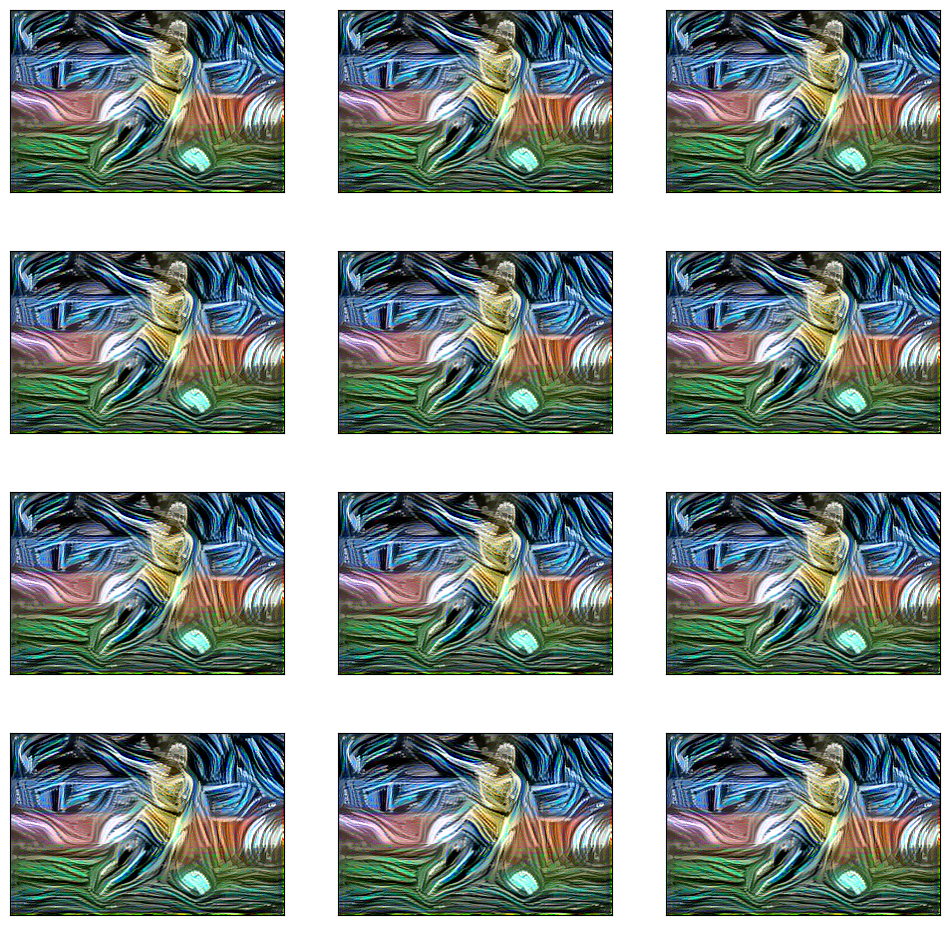

In [16]:
plt.figure(figsize=(12, 12))  # Set the figure size

# Loop through to plot last 12 generated images in a 4x3 grid (4 rows, 3 columns)
for i in range(12):
    plt.subplot(4, 3, i + 1)  # Create subplots for 4 rows and 3 columns
    display_image(generated_images[i + 87])  # Display image from the 87th index onwards

# Show all the subplots at once
plt.show()

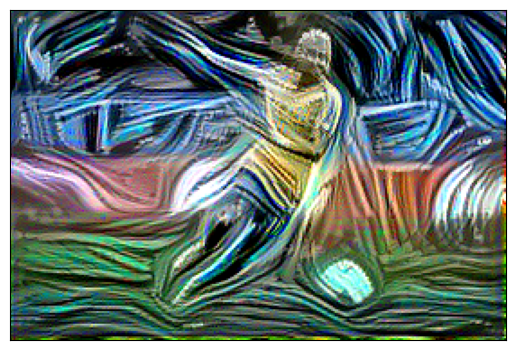

In [17]:
# plot best result
display_image(final_img)

## Examples For Testing

![alt text](<Style Transfer Examples-2.png>)